In [8]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!unzip /content/custom_dataset.zip -d /content/custom_dataset



Archive:  /content/custom_dataset.zip
  inflating: /content/custom_dataset/input/img0.png  
  inflating: /content/custom_dataset/input/img1.png  
  inflating: /content/custom_dataset/input/img2.png  
  inflating: /content/custom_dataset/input/img3.png  
  inflating: /content/custom_dataset/input/img4.png  
  inflating: /content/custom_dataset/input/img5.png  
  inflating: /content/custom_dataset/input/img6.png  
  inflating: /content/custom_dataset/input/img7.png  
  inflating: /content/custom_dataset/input/img8.png  
  inflating: /content/custom_dataset/input/img9.png  
  inflating: /content/custom_dataset/input/img10.png  
  inflating: /content/custom_dataset/input/img11.png  
  inflating: /content/custom_dataset/input/img12.png  
  inflating: /content/custom_dataset/input/img13.png  
  inflating: /content/custom_dataset/input/img14.png  
  inflating: /content/custom_dataset/input/img15.png  
  inflating: /content/custom_dataset/input/img16.png  
  inflating: /content/custom_dataset/

In [9]:
class ImageToImageDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir)])
        self.output_paths = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_paths[idx]).convert("RGB")
        output_img = Image.open(self.output_paths[idx]).convert("RGB")
        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)
        return input_img, output_img

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageToImageDataset("custom_dataset/input", "custom_dataset/output", transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [12]:
def imshow(tensor):
    # Convert tensor from (C, H, W) to (H, W, C) and denormalize it
    img = tensor.cpu().detach().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [13]:
for epoch in range(20):  # epochs
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for the current epoch
    print(f"Epoch {epoch+1}/20 - Loss: {loss.item():.4f}")

Epoch 1/20 - Loss: 0.0532
Epoch 2/20 - Loss: 0.0472
Epoch 3/20 - Loss: 0.0418
Epoch 4/20 - Loss: 0.0341
Epoch 5/20 - Loss: 0.0330
Epoch 6/20 - Loss: 0.0270
Epoch 7/20 - Loss: 0.0229
Epoch 8/20 - Loss: 0.0198
Epoch 9/20 - Loss: 0.0182
Epoch 10/20 - Loss: 0.0176
Epoch 11/20 - Loss: 0.0161
Epoch 12/20 - Loss: 0.0154
Epoch 13/20 - Loss: 0.0138
Epoch 14/20 - Loss: 0.0127
Epoch 15/20 - Loss: 0.0109
Epoch 16/20 - Loss: 0.0119
Epoch 17/20 - Loss: 0.0113
Epoch 18/20 - Loss: 0.0102
Epoch 19/20 - Loss: 0.0087
Epoch 20/20 - Loss: 0.0079


Epoch 20 - Displaying input, output, and target images:


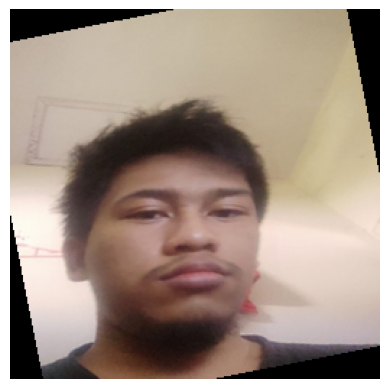

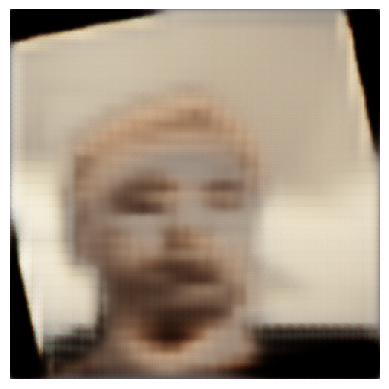

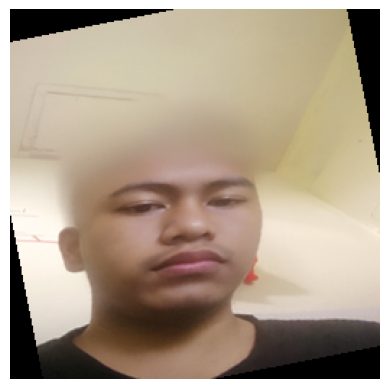

In [15]:

    print(f"Epoch {epoch+1} - Displaying input, output, and target images:")
    imshow(inputs[1])
    imshow(outputs[1])
    imshow(targets[1])